In [10]:
import xlwings as xw
import pandas as pd
import pyautocad

Импорт таблицы в Autocad

In [6]:
sheet = xw.sheets.active
df = sheet.range('A1').expand().options(pd.DataFrame, header=1, index=False).value
df['Номер'] = df['Номер'].apply(lambda x: str(int(float(x))))
df = df[['Номер', 'Наименование', 'Количество', 'Высота', 'Толщина', 'Состояние', 'Действие']]
df

,Номер,Наименование,Количество,Высота,Толщина,Состояние,Действие
0,316,береза,7.4 м.кв.,1.0,0.05,Хорошее,Удаление
1,317,ольха,7.4 м.кв.,2.5,0.08,Хорошее,Удаление
2,307,береза,30.7 м.кв.,1.5,0.05,Хорошее,Удаление
3,308,ольха,30.7 м.кв.,2.0,0.06,Хорошее,Удаление
4,305,Яблоня домашняя,2 ствола,1.5х2,0.04х2,Хорошее,Удаление
5,306,Яблоня домашняя,4,1.5х4,0.04х4,Хорошее,Удаление
6,309,Яблоня домашняя,3,1.5х3,0.03х3,Хорошее,Удаление
7,312,Яблоня домашняя,2 ствола,1.5х2,0.04х2,Хорошее; плохое,Удаление
8,310,Яблоня домашняя,2,1.5х2,0.03х2,Хорошее,Удаление
9,314,Алыча,1.7 м.п.,2.0,0.07,Хорошее,Удаление


In [12]:
# из документации pyautocad

from pyautocad import Autocad, APoint

acad = Autocad()
p1 = APoint(0, 0)
for i in range(5):
    obj = acad.model.AddText(u'Hi %s!' % i, p1, 2.5)
    p1.y += 10

# вывод: делаю модуль для рисования таблицы с помощью линий и текста

In [47]:
class StyleTableExists:
    layer = 'Таксация_Таблица существующих'
    color = '7'
    class TableSize:
        class Column:
            number = 1005.4436
            name = 6000.1037
            quantity = 1427.5616
            height = 1500.0259
            diameter = 1572.4902
            quality = 4000.0691
            description = 3000.0058
            full = number + name + quantity + height + diameter + quality + description
        class Row:
            column_name = 1500.0259
            zone = 800.0138
            orm = 800.0138
    class TextTitle:
        style = 'NF_VGP_5.0'
        height = 400.268
    class TextColumnName:
        style = 'NF_VGP_3.0'
        height = 300
    class TextZone:
        style = 'NF_VGP_5.0'
        height = 300
    class TextORM:
        style = 'NF_VGP_3.0'
        height = 300
        h_margin = 100

In [64]:
from shapely import LineString, MultiLineString, Point
from shapely.affinity import translate
import pandas as pd

class Table:
    def __init__(self) -> None:
        self._h_line_strings: list[LineString] = []
        self._v_line_strings: list[LineString] = []
        self._y: float = 0.0
        self._text: dict[str: list[tuple[str, float, float]]] = {'Title': [], 'ColumnName': [], 'Zone': [], 'ORM': []}
    
    def _show(self) -> MultiLineString:
        lines = self._h_line_strings + self._v_line_strings
        for k ,v in self._text.items():
            for text, x, y in v:
                lines.append(LineString([[x, y], [x+300, y]]))
        return MultiLineString(lines)
    
    def _next_h_line(self, width: float) -> LineString:
        line = LineString([(0, self._y), (width, self._y)])
        return line
    
    def _next_v_line(self, height: float) -> LineString:
        line = LineString([(0, self._y - height), (0, self._y)])
        self._y = self._y - height
        return line
    
    def _add_h_lines(self, lines: list[LineString]) -> None:
        self._h_line_strings = list(set(self._h_line_strings + lines))
    
    def _add_v_lines(self, lines: list[LineString]) -> None:
        self._v_line_strings = list(set(self._v_line_strings + lines))
    
    def add_title_row(self, values: list[str]) -> None:
        height = StyleTableExists.TableSize.Row.column_name
        width = StyleTableExists.TableSize.Column.full
        text_y = self._y - height / 2
        h_line = self._next_h_line(width)
        h_lines = [h_line, translate(h_line, yoff=-height)]
        self._add_h_lines(h_lines)
        v_line = self._next_v_line(height)
        v_lines = [v_line]
        column_widths = [
            StyleTableExists.TableSize.Column.number,
            StyleTableExists.TableSize.Column.name,
            StyleTableExists.TableSize.Column.quantity,
            StyleTableExists.TableSize.Column.height,
            StyleTableExists.TableSize.Column.diameter,
            StyleTableExists.TableSize.Column.quality,
            StyleTableExists.TableSize.Column.description
        ]
        spacing = 0
        for step, text in zip(column_widths, values):
            text_x = spacing + step / 2
            self._text['ColumnName'].append((text, text_x, text_y))
            spacing += step
            v_lines.append(translate(v_line, xoff=spacing))
        self._add_v_lines(v_lines)
    
    def add_zone_row(self, value: str) -> None:
        width = StyleTableExists.TableSize.Column.full
        height = StyleTableExists.TableSize.Row.zone
        text_y = self._y - height / 2
        text_x = width / 2
        self._text['Zone'].append((value, text_x, text_y))
        h_line = self._next_h_line(width)
        v_line = self._next_v_line(height)
        h_lines = [h_line, translate(h_line, yoff=-height)]
        self._add_h_lines(h_lines)
        v_lines = [v_line, translate(v_line, xoff=width)]
        self._add_v_lines(v_lines)
    
    def add_orm_row(self, values: list[str]) -> None:
        width = StyleTableExists.TableSize.Column.full
        height = StyleTableExists.TableSize.Row.zone
        text_y = self._y - height + (height - StyleTableExists.TextORM.height) / 2
        h_line = self._next_h_line(width)
        h_lines = [h_line, translate(h_line, yoff=-height)]
        self._add_h_lines(h_lines)
        v_line = self._next_v_line(height)
        v_lines = [v_line]
        column_widths = [
            StyleTableExists.TableSize.Column.number,
            StyleTableExists.TableSize.Column.name,
            StyleTableExists.TableSize.Column.quantity,
            StyleTableExists.TableSize.Column.height,
            StyleTableExists.TableSize.Column.diameter,
            StyleTableExists.TableSize.Column.quality,
            StyleTableExists.TableSize.Column.description
        ]
        spacing = 0
        margin = StyleTableExists.TextORM.h_margin
        for step, text in zip(column_widths, values):
            text_x = spacing + margin
            self._text['ORM'].append((text, text_x, text_y))
            spacing += step
            v_lines.append(translate(v_line, xoff=spacing))
        self._add_v_lines(v_lines)
        

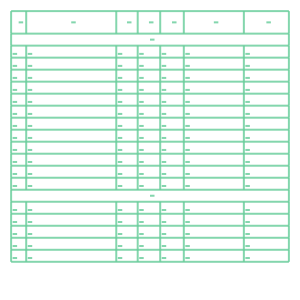

In [65]:
titles = ['Номер точки', 'Наименование', 'Кол-во,\pшт.', 'Высота,\pм', 'Диаметр\pствола,\pсм', 
          'Качественное\pсостояние', 'Примечание']
orm = ['Номер точки', 'Наименование', 'Количество', 'Высота', 'Толщина', 'Состояние', 'Примечание']
zone = 'Граница благоустройства'
table = Table()
table.add_title_row(titles)
table.add_zone_row(zone)
for i in range(12):
    table.add_orm_row(orm)
table.add_zone_row(zone)
for i in range(5):
    table.add_orm_row(orm)

table._show()

In [25]:
l = LineString([[0, 0], [0+100, 0]])
l.xy
# l.xy[1] + (800 - StyleTableExists.TextORM.height) / 2

(array('d', [0.0, 100.0]), array('d', [0.0, 0.0]))